In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import StrMethodFormatter


In [8]:
# Mount Google Drive (if needed)
drive.mount('/content/drive')

# Load the data
# the file path changes depending on the necessary csv file
file_path = '/content/drive/My Drive/HRTF_noise/results_for_graphs/Mean Quadrant Error (%) Results.csv'
data = pd.read_csv(file_path, index_col=0, na_values=['NaN', ''])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


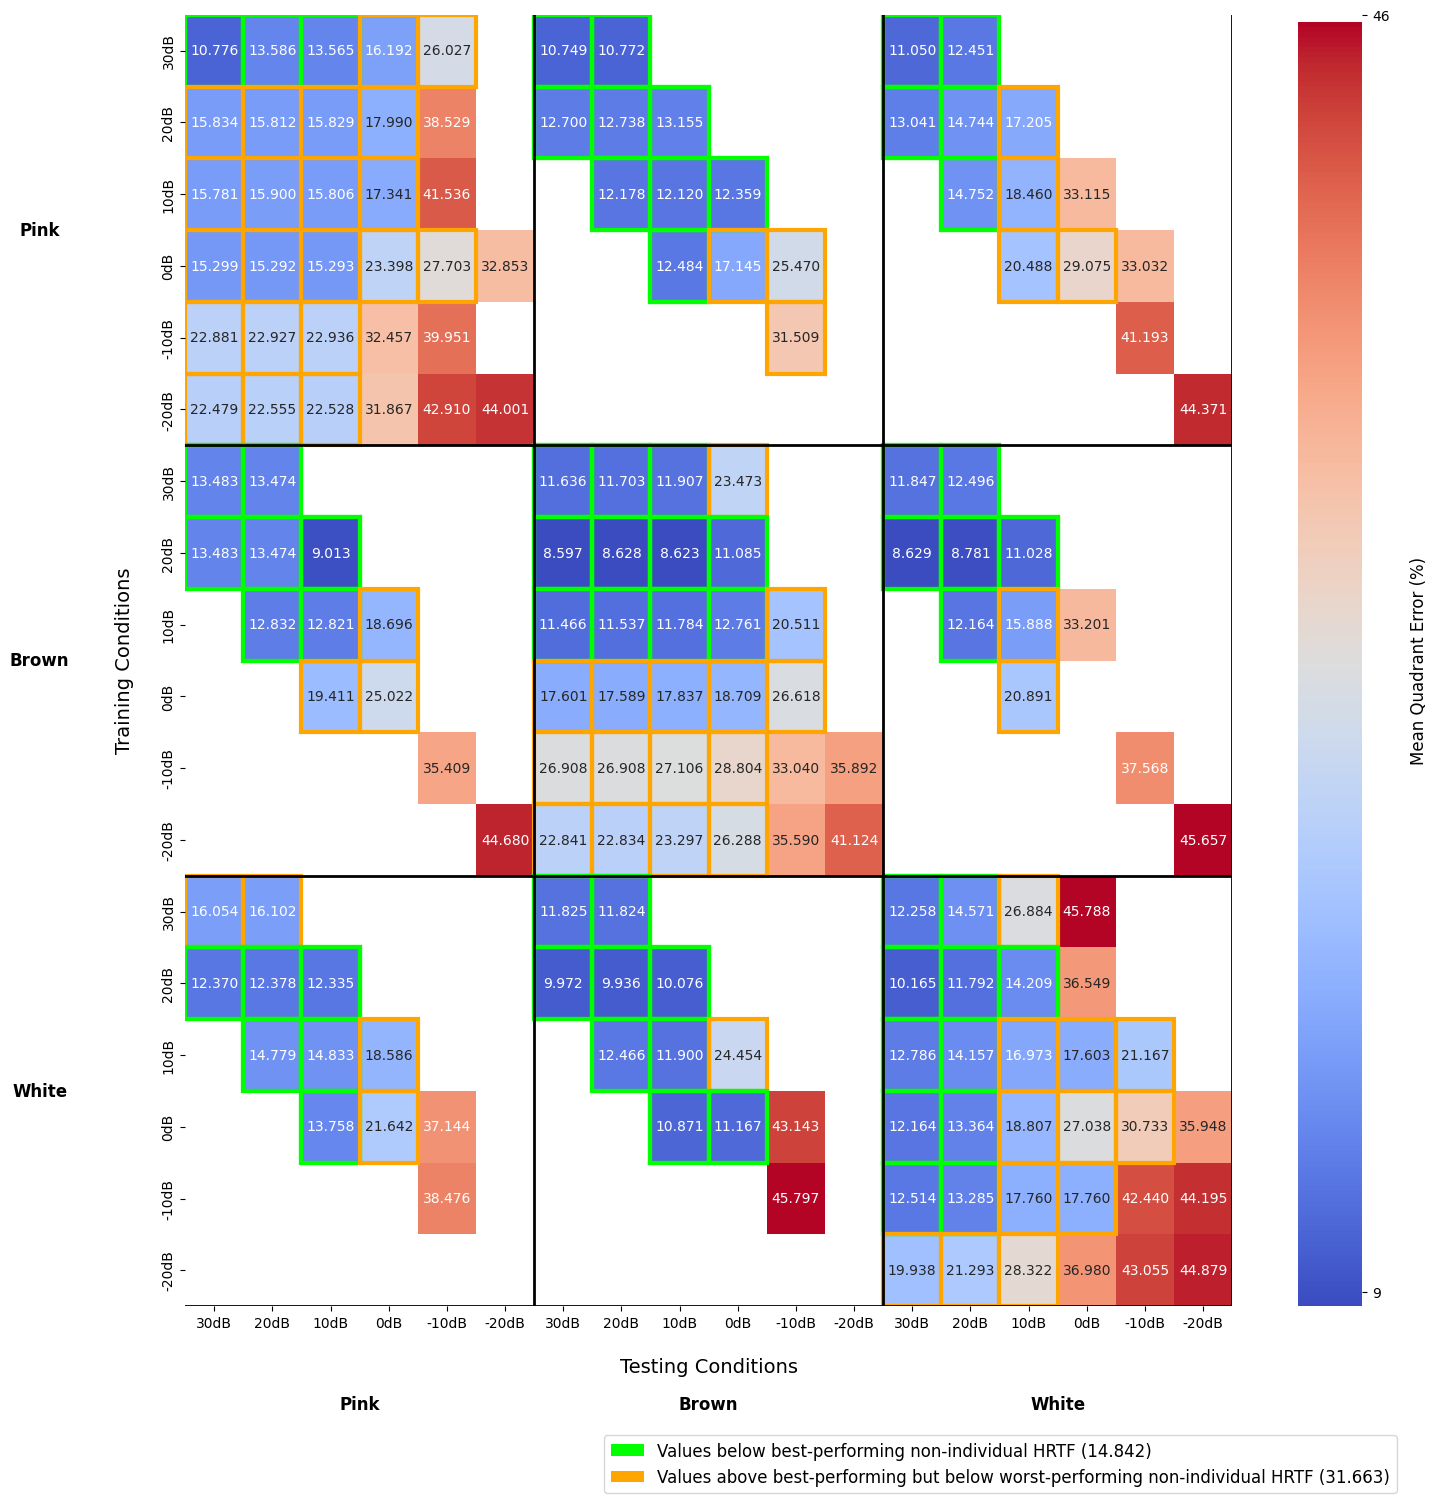

In [11]:
"""
This cell creates the heat maps and applies a specific color scheme
"""

# Define performance thresholds
best = 14.842
worst = 31.663

# Create masks for highlighting
mask_best = data < best
mask_between = (data >= best) & (data <= worst)

# Mask NaN values
masked_data = np.ma.masked_invalid(data)

# Set up the figure with a larger size
plt.figure(figsize=(15, 15))

# Create the main heatmap with a diverging colormap
heatmap = sns.heatmap(masked_data, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'LSD'})

# Get the axis object for adding patches
ax = plt.gca()

# Function to add borders to cells based on a mask and data value
def add_borders(data, mask, color, lw):
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask.iloc[i, j]:
                # Add separate rectangle for each cell in mask_between
                rect = Rectangle((j, i), 1, 1, fill=False, edgecolor=color, lw=lw)
                ax.add_patch(rect)
            elif data.iloc[i, j] < best:
                rect = Rectangle((j, i), 1, 1, fill=False, edgecolor='lime', lw=3)  # Bright green border for lower LSD cells
                ax.add_patch(rect)

# Add borders for best performing cells with active green color
add_borders(data, mask_best, 'lime', 3)  # Active green color with linewidth 3

# Add borders for cells between the thresholds with neon orange color
add_borders(data, mask_between, '#FFA500', 3)  # Neon orange color with linewidth 3

# Add custom lines to separate noise types
lines_positions = [6, 12, 18]
for pos in lines_positions:
    ax.axhline(pos, color='black', linewidth=2)
    ax.axvline(pos, color='black', linewidth=2)

# Add noise type headings on both axes
noise_types = data.index.str.split(' ').str[0].unique()
for i, noise_type in enumerate(noise_types):
    ax.text(-2.5, i * 6 + 3, noise_type, ha="center", va="center", rotation=0, fontsize=12, weight='bold')

# Adjust y-coordinate for the top noise type labels
for i, noise_type in enumerate(noise_types):
    ax.text(i * 6 + 3, 19.5, noise_type, ha="center", va="bottom", rotation=0, fontsize=12, weight='bold')

# Simplify column and row labels
ax.set_xticks(np.arange(len(data.columns)) + 0.5)
ax.set_xticklabels([label.split(' ')[-2] for label in data.columns])

ax.set_yticks(np.arange(len(data.index)) + 0.5)
ax.set_yticklabels([label.split(' ')[-2] for label in data.index])

# Set labels and title
plt.xlabel('Testing Conditions', labelpad=20, fontsize=14)
plt.ylabel('Training Conditions', labelpad=20, fontsize=14)

# Customize colorbar ticks and label
cbar = heatmap.collections[0].colorbar
min_lsd = np.round(data.min().min(), decimals=0)  # Minimum non-NaN LSD value
max_lsd = np.round(data.max().max(), decimals=0)  # Maximum non-NaN LSD value
cbar.set_ticks([min_lsd, max_lsd])  # Display min and max LSD values rounded to nearest whole number
cbar.set_label('Mean Quadrant Error (%)', labelpad=15, fontsize=12)

# Adjust legend position next to "Testing Conditions" label on the right side
legend_texts = [
    'Values below best-performing non-individual HRTF (14.842)',
    'Values above best-performing but below worst-performing non-individual HRTF (31.663)'
]

legend_colors = ['lime', '#FFA500']  # Use 'lime' instead of hex code for active green
legend_patches = [Rectangle((0, 0), 1, 1, linewidth=0, edgecolor=color, facecolor=color) for color in legend_colors]

# Position the legend next to "Testing Conditions" label on the right side
plt.legend(legend_patches, legend_texts, loc='upper left', fontsize=12, bbox_to_anchor=(0.4, -0.1), borderaxespad=0.)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/heatmap_matrix_mean_quadrant_errors.png',dpi=300)

# Show the plot
plt.show()


In [ ]:
# Load the data for subsequent cells
file_path = '/content/drive/My Drive/HRTF_noise/results_for_graphs/LSD and perceptual results in column form.csv'
data = pd.read_csv(file_path, na_values=['NaN', ''])

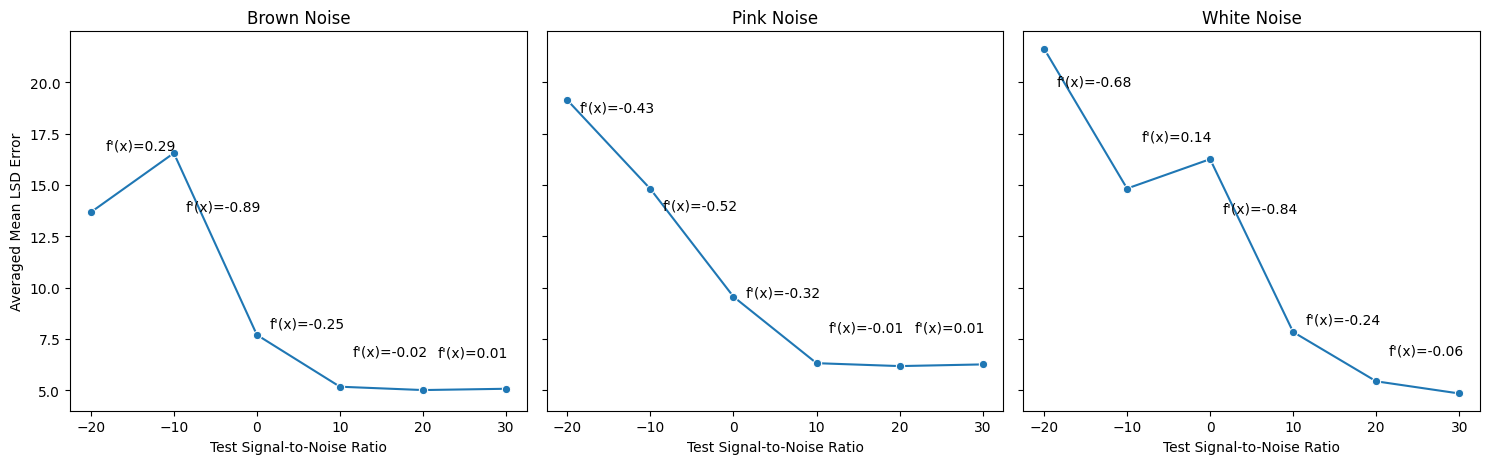

In [ ]:
"""
This cell creates the graph that displays the rate of change in the averaged mean LSD when varying the train SNR and test SNR by noise type
"""

# Filter out rows where `LSD` is null
filtered_df = data.dropna(subset=['LSD'])

# Group by `Test Noise Type` and `Test Noise Level`, and calculate the mean `LSD`
grouped_df = filtered_df.groupby(['Test Noise Type', 'Test Noise Level'], as_index=False)['LSD'].mean()

# Create a figure with three subplots (1 row, 3 columns) sharing a y-axis
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)


# Iterate through the unique `Test Noise Type` values
for i, train_noise_type in enumerate(grouped_df['Test Noise Type'].unique()):
    # Filter the grouped data for the current `Test Noise Type`
    df_filtered = grouped_df[grouped_df['Test Noise Type'] == train_noise_type]

    # Sort by `Test Noise Level`
    df_filtered = df_filtered.sort_values(by='Test Noise Level')

    # Plot on the corresponding subplot
    sns.lineplot(data=df_filtered, x='Test Noise Level', y='LSD', ax=axes[i], marker='o')
    axes[i].set_title(f'{train_noise_type} Noise')

    if i == 0:  # Set the y-axis label only for the first subplot since they share the y-axis
        axes[i].set_ylabel('Averaged Mean LSD Error')
    else:
        axes[i].set_ylabel('')

    # Set the x-axis label for each subplot
    axes[i].set_xlabel('Test Signal-to-Noise Ratio')

    # Calculate and annotate slopes
    for j in range(len(df_filtered) - 1):
        x1, y1 = df_filtered.iloc[j]['Test Noise Level'], df_filtered.iloc[j]['LSD']
        x2, y2 = df_filtered.iloc[j + 1]['Test Noise Level'], df_filtered.iloc[j + 1]['LSD']
        slope = (y2 - y1) / (x2 - x1)
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2
        # Annotate with slope, adjusting position
        axes[i].annotate(f'f\'(x)={slope:.2f}', xy=(mid_x, mid_y), textcoords="offset points", xytext=(6,24), ha='center')

# Adjust layout to make room for the main title
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/changes_in_LSD_due_to_test.png',dpi=300)

# Display the plot
plt.show()


In [ ]:
"""
This cell calculates the top 10 best-performing models for the four performance metrics
"""

# Define the metrics and their corresponding column names
metrics = {
    'LSD': 'LSD',
    'Mean Polar ACC Error (Degrees)': 'Mean Polar ACC Error',
    'Mean Polar RMS Error (Degrees)': 'Mean Polar RMS Error',
    'Mean Quadrant Error (%)': 'Mean Quadrant Error'
}

# Filter out rows with missing values in the specified columns
filtered_df = data.dropna(subset=['Train Noise Type', 'Train Noise Level'] + list(metrics.keys()))

# Iterate through each metric
for metric_col, metric_name in metrics.items():
    # Determine the sorting column based on the metric
    sort_col = metric_col if metric_name == 'LSD' else f'Absolute {metric_name}'

    # Calculate the absolute value only if it's not the LSD metric
    if metric_name != 'LSD':
        filtered_df[f'Absolute {metric_name}'] = filtered_df[metric_col].abs()

    # Group by `Train Noise Type` and `Train Noise Level`, and calculate the mean of the metric
    grouped_df = filtered_df.groupby(['Train Noise Type', 'Train Noise Level'], as_index=False)[sort_col].mean()

    # Sort the grouped DataFrame by the mean metric in ascending order
    grouped_df_sorted = grouped_df.sort_values(sort_col)

    # Select the top 10 rows
    top_10_df = grouped_df_sorted.head(10)

    # Rename the metric column for clarity in the output
    top_10_df = top_10_df.rename(columns={sort_col: metric_name})

    # Print the top 10 rows in markdown format
    print(f"\nTop 10 for {metric_name}:\n")
    print(top_10_df.to_markdown(index=False, numalign="left", stralign="left"))


Top 10 for LSD:

| Train Noise Type   | Train Noise Level   | LSD     |
|:-------------------|:--------------------|:--------|
| Brown              | 20                  | 4.1531  |
| Brown              | 10                  | 5.13682 |
| Brown              | 30                  | 5.3265  |
| Pink               | 30                  | 6.80222 |
| Pink               | 20                  | 6.99945 |
| White              | 20                  | 7.06    |
| White              | 10                  | 8.03882 |
| Brown              | 0                   | 8.34137 |
| Pink               | 10                  | 8.35127 |
| White              | 30                  | 9.32475 |

Top 10 for Mean Polar ACC Error:

| Train Noise Type   | Train Noise Level   | Mean Polar ACC Error   |
|:-------------------|:--------------------|:-----------------------|
| White              | 20                  | 1.6247                 |
| Brown              | 20                  | 2.1211                 |
| Brown

<ipython-input-11-12b465dcf87a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[f'Absolute {metric_name}'] = filtered_df[metric_col].abs()
<ipython-input-11-12b465dcf87a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[f'Absolute {metric_name}'] = filtered_df[metric_col].abs()
<ipython-input-11-12b465dcf87a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

The code below is used for graphs related to personalization checks

In [ ]:
# Load the data
file_path = '/content/drive/My Drive/HRTF_noise/results_for_graphs/personalization test results.csv'
data = pd.read_csv(file_path, na_values=['NaN', ''])
print (data.columns)

Index(['Train Condition', 'Test Condition',
       'Overall Mean LSD Error (against all other subjects)',
       'Overall Standard Deviation', 'Mean LSD Error (within subject)',
       'Difference in Mean LSD Error', 'Difference in LSD Above Sd?',
       'NaN corresponds with the original experiments',
       'Number of experiments', 'Number of experiments with above-sd results ',
       'Number of experiments within sd ', 'Number of NaNs',
       'Number of experiments with results', 'Percentage of out-of-sd values ',
       'Percentage of within-sd-values'],
      dtype='object')


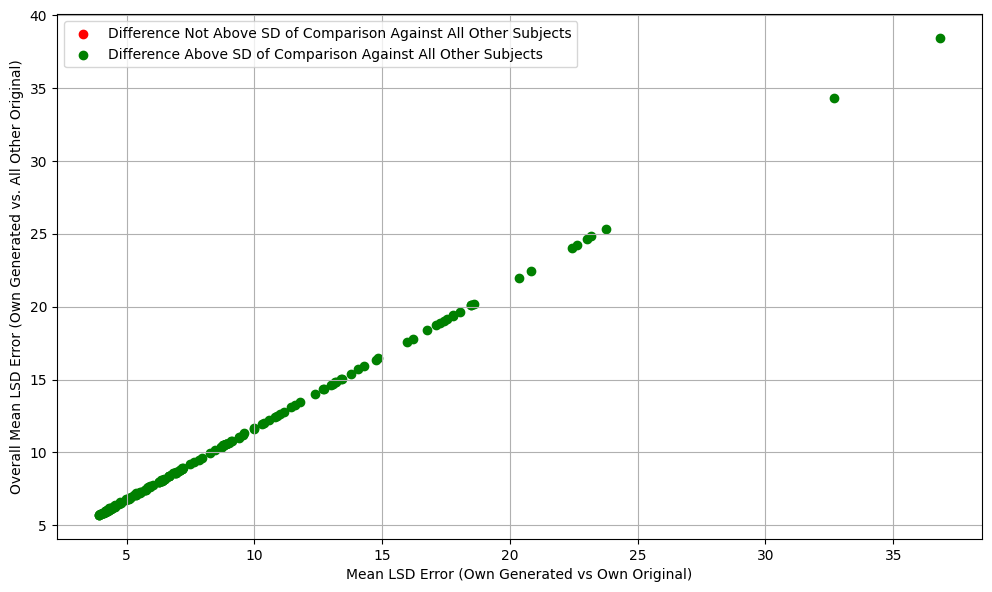

In [ ]:
"""
This cell creates the figure that plots the mean LSD error (own generated vs. original) on the x axis
and the overall mean LSD on the y axis (own generated vs. all others)
"""

# Filter for rows where 'Difference in LSD Above Sd?' is False
filtered_data_red = data[data['Difference in LSD Above Sd?'] == 'FALSE']

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot points where the difference is NOT above the standard deviation (red)
plt.scatter(filtered_data_red['Mean LSD Error (within subject)'], filtered_data_red['Overall Mean LSD Error (against all other subjects)'],
            c='red', label='Difference Not Above SD of Comparison Against All Other Subjects')

# Plot the rest of the points (green)
plt.scatter(data['Mean LSD Error (within subject)'], data['Overall Mean LSD Error (against all other subjects)'],
            c='green', label='Difference Above SD of Comparison Against All Other Subjects')

# Add title and labels
#plt.title('Figure 4: Mean LSD Error When Using Subject\'s Original HRTF vs. All Other Subjects\' Original', pad=20)
plt.xlabel('Mean LSD Error (Own Generated vs Own Original)')
plt.ylabel('Overall Mean LSD Error (Own Generated vs. All Other Original)')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Adjust layout to prevent title from being cut off
plt.tight_layout(pad=1.0)

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/lsd_differences.png', dpi=300)

# Show the plot
plt.show()

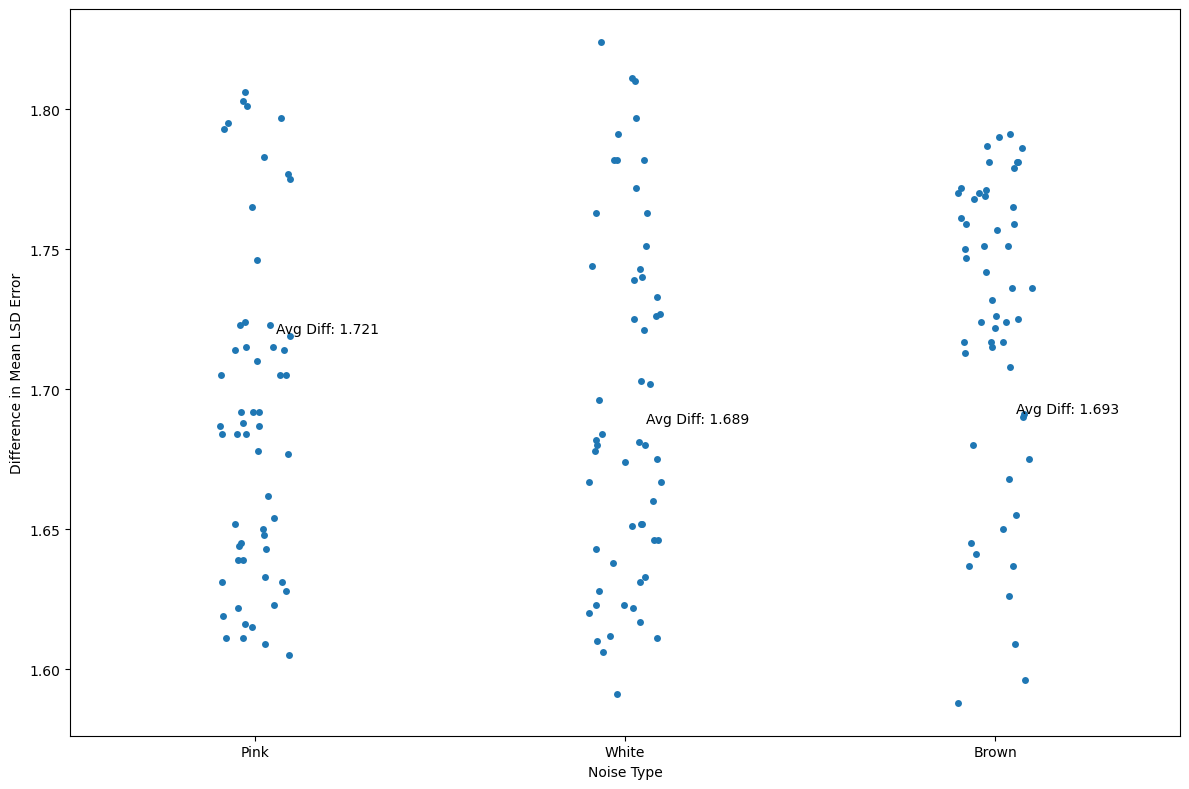

In [ ]:
"""
This cell creates the figure that plots the distribution of the difference between the averaged mean LSD and the mean LSD for every noise type
"""
# Extract the first word from each cell in the 'Train Condition' column to get the noise type
data['Noise Type'] = data['Train Condition'].astype(str).str.split().str[0]

# Create a strip plot using seaborn
plt.figure(figsize=(12, 8))
strip_plot = sns.stripplot(x='Noise Type', y='Difference in Mean LSD Error', data=data, jitter=True, size=5)

# Calculate average difference in mean LSD error for each noise type
avg_diff_by_noise = data.groupby('Noise Type')['Difference in Mean LSD Error'].mean()

# Annotate with average values, adjusting x-coordinate for label position
for i, avg_diff in enumerate(avg_diff_by_noise):
    plt.annotate(f'Avg Diff: {avg_diff:.3f}', xy=(i, avg_diff), xytext=(15, 0), textcoords='offset points',
                 ha='left', va='center', fontsize=10)

# Add title and labels
#plt.title('Figure 5: Difference in Mean LSD Error Between Own HRTF and Against-All-Other-Subjects Averages by Train Noise Type')
plt.xlabel('Noise Type')
plt.ylabel('Difference in Mean LSD Error')

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/lsd_differences_by_noise_type.png',dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

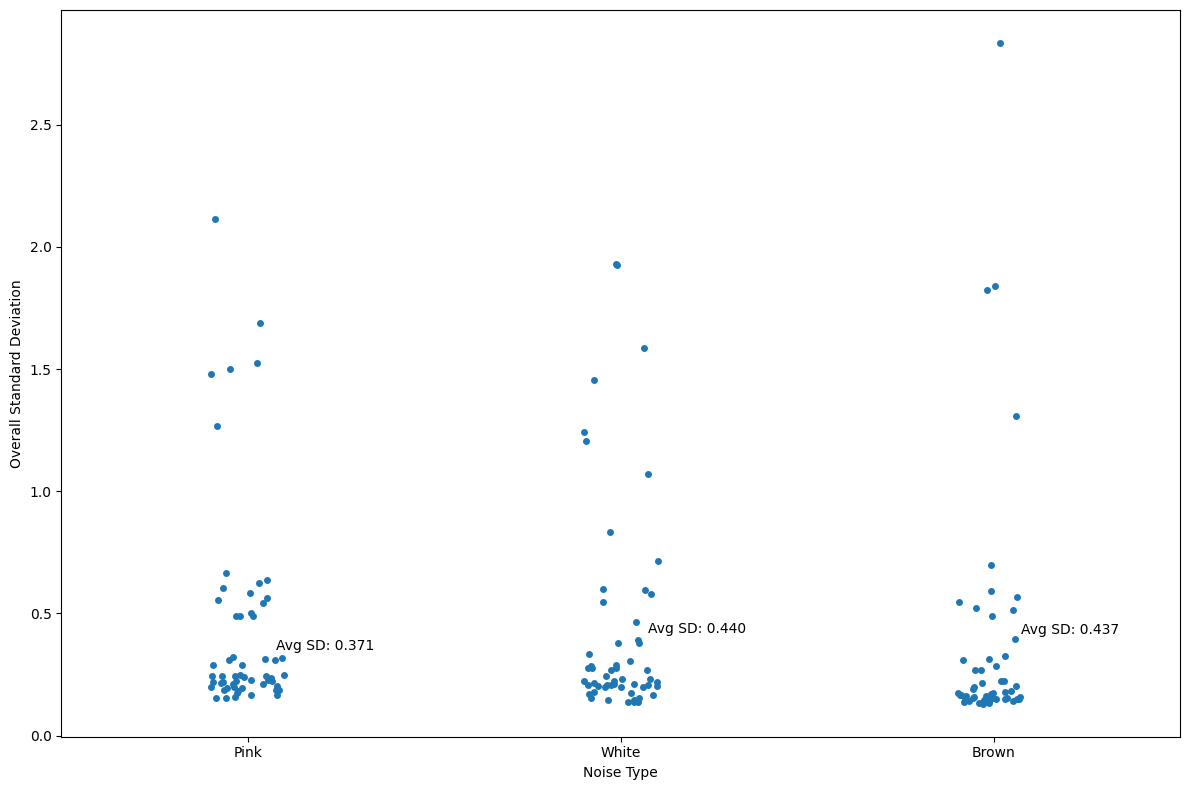

In [ ]:
"""
This cell creates the figure that plots the distribution of standard deviations by noise type for the experments where the LSD of a subject
is compared to that of all other subjects
"""
# Extract the first word from each cell in the 'Train Condition' column to get the noise type
data['Noise Type'] = data['Train Condition'].astype(str).str.split().str[0]

# Create a strip plot using seaborn
plt.figure(figsize=(12, 8))
strip_plot = sns.stripplot(x='Noise Type', y='Overall Standard Deviation', data=data, jitter=True, size=5)

# Calculate average SD for each noise type
avg_sd_by_noise = data.groupby('Noise Type')['Overall Standard Deviation'].mean()

# Annotate with average SD values
for i, avg_sd in enumerate(avg_sd_by_noise):
 plt.annotate(f'Avg SD: {avg_sd:.3f}', xy=(i, avg_sd), xytext=(20, -1), textcoords='offset points',
                 ha='left', va='center', fontsize=10)

# Add title and labels
#plt.title('Figure 6: Standard Deviation of Against-All-Other-Subjects Mean LSD Error by Train Noise Type')
plt.xlabel('Noise Type')
plt.ylabel('Overall Standard Deviation')

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/lsd_differences_standard_deviation_by_noise_type.png',dpi=300)


# Show the plot
plt.tight_layout()
plt.show()

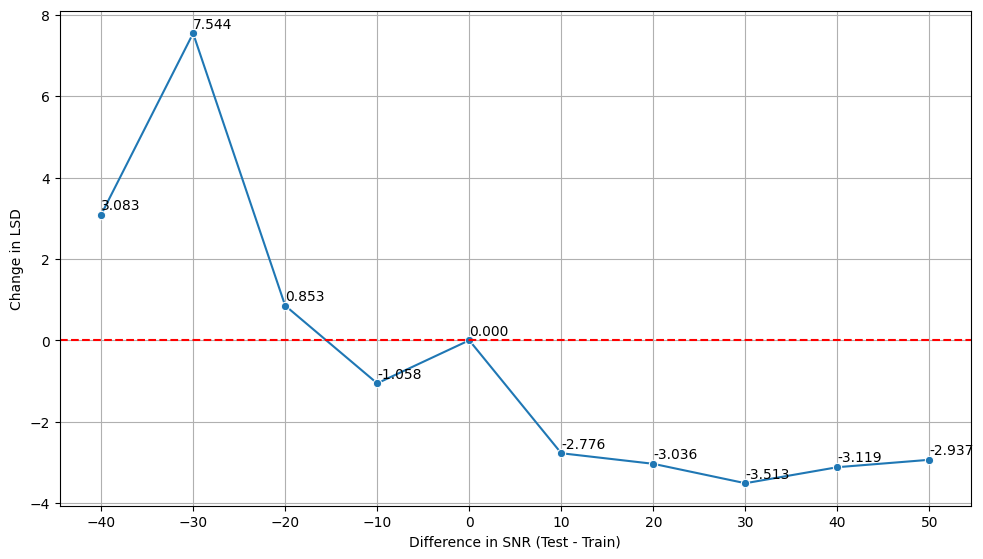

In [ ]:
"""
This cell plots the figure that shows the average change in LSD across SNR differences between test and train noise levels relative to no differences
"""

# Filter for rows where Train Noise Level equals Test Noise Level (same SNR for both)
same_snr = data[data['Train Noise Level'] == data['Test Noise Level']].copy()

# Rename LSD column for clarity
same_snr.rename(columns={'LSD': 'LSD_same_SNR'}, inplace=True)

# Merge the data with same_snr to get the LSD_same_SNR for each Train/Test Noise Type combination
merged = pd.merge(data, same_snr[['Train Noise Type', 'Test Noise Type', 'LSD_same_SNR']],
                  on=['Train Noise Type', 'Test Noise Type'])

# Calculate the relative change in LSD
merged['LSD_change'] = merged['LSD'] - merged['LSD_same_SNR']

# Calculate the difference in SNR between Test and Train Noise Levels
merged['SNR_difference'] = merged['Test Noise Level'] - merged['Train Noise Level']

# Group by SNR_difference and calculate the mean relative change in LSD
grouped = merged.groupby('SNR_difference')['LSD_change'].mean().reset_index()

# Drop NaN values if there are any
grouped.dropna(inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped, x='SNR_difference', y='LSD_change', marker='o')
#plt.title('Figure 7: Average Change in LSD Across SNR Differences Between Test and Train Noise Levels Relative to No Differences')
plt.xlabel('Difference in SNR (Test - Train)')
plt.ylabel('Change in LSD')
plt.grid(True)

# Set x-ticks to step by 10
plt.xticks(range(int(grouped['SNR_difference'].min()), int(grouped['SNR_difference'].max()) + 10, 10))

# Add labels to the data points, move labels a bit up
for idx, row in grouped.iterrows():
    plt.text(row['SNR_difference'], row['LSD_change'] + 0.06,  # Move labels
             f"{row['LSD_change']:.3f}",
             horizontalalignment='left',
             verticalalignment='bottom',
             size='medium',
             color='black')

# Add a horizontal line at 0 SNR difference
plt.axhline(0, color='red', linewidth=1.5, linestyle='--')

# Adjust layout to make room for title and labels
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot with bbox_inches='tight' to ensure nothing is cropped
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/average_change_in_LSD_SNR_changes.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

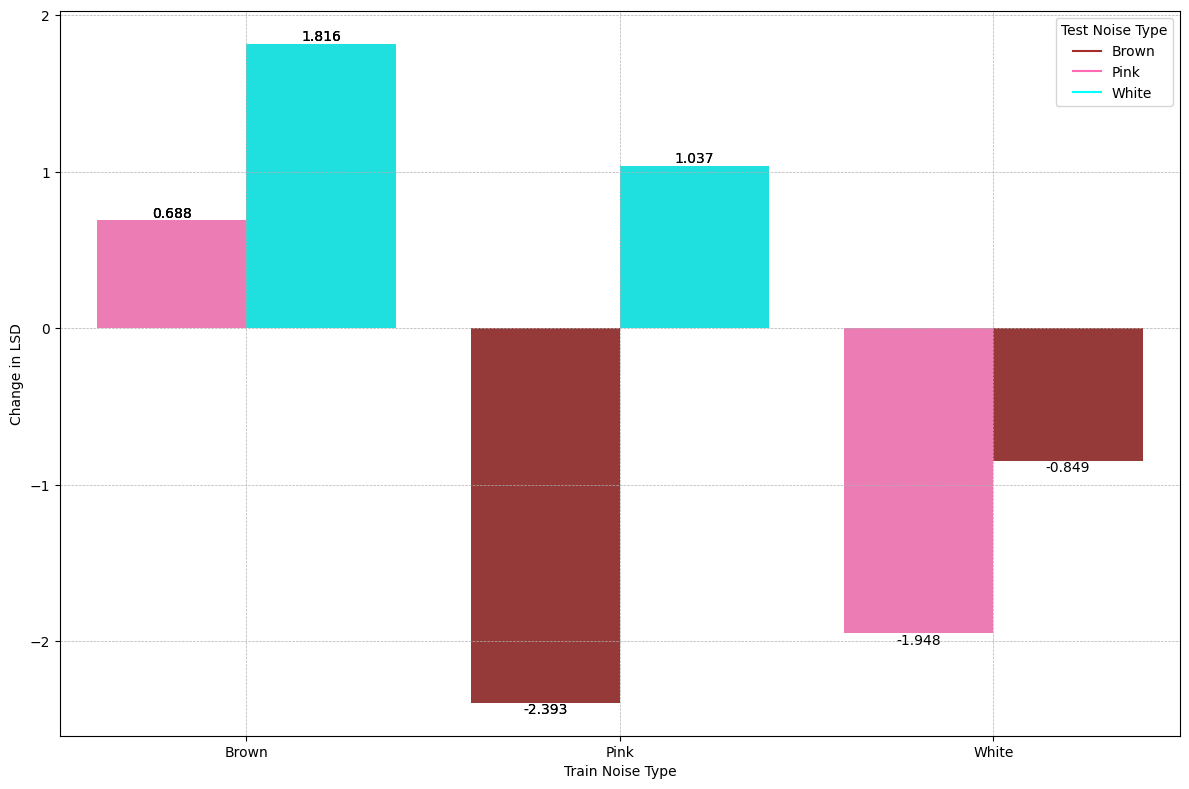

In [ ]:
"""
This cell plots the figure that shows how changing the test noise type changes the LSD for every noise type, holding the train noise type constant
"""

# Step 1: Calculate the baseline LSD (when Train Noise Type equals Test Noise Type)
baseline = data[data['Train Noise Type'] == data['Test Noise Type']].copy()
baseline.rename(columns={'LSD': 'LSD_baseline'}, inplace=True)

# Step 2: Merge the baseline data with the original data
merged = pd.merge(data, baseline[['Train Noise Type', 'Train Noise Level', 'LSD_baseline']],
                  on=['Train Noise Type', 'Train Noise Level'])

# Step 3: Calculate the relative change in LSD
merged['LSD_change'] = merged['LSD'] - merged['LSD_baseline']

# Filter out rows where Train Noise Type equals Test Noise Type
filtered_grouped = merged[merged['Train Noise Type'] != merged['Test Noise Type']]

# Define the order of Train Noise Types
train_order = ['Brown', 'Pink', 'White']  # Define the overall order of Train Noise Types

# Define the order of Test Noise Types for each Train Noise Type
test_order_white = ['Brown', 'Pink', 'White']  # Define the order of Test Noise Types when Train Noise Type is White
test_order_other = ['Brown', 'White', 'Pink']  # Define the order of Test Noise Types for other Train Noise Types

# Define the color mapping for each noise type
color_map = {'Brown': 'brown', 'Pink': 'hotpink', 'White': 'cyan'}

# Plotting with adjusted color palette and bar width
plt.figure(figsize=(12, 8))

# Initialize legend handles and labels
handles = []
labels = []

# Iterate over each Train Noise Type and plot bars for each Test Noise Type
for i, train_type in enumerate(train_order):
    # Filter subset for the current Train Noise Type
    subset = filtered_grouped[filtered_grouped['Train Noise Type'] == train_type]

    # Determine the order of Test Noise Types based on Train Noise Type
    if train_type == 'White':
        order = test_order_white
    else:
        order = test_order_other

    # Plot bars for current Train Noise Type and collect handles and labels
    ax = sns.barplot(data=subset, x='Train Noise Type', y='LSD_change', hue='Test Noise Type', palette=color_map, dodge=True, order=[train_type], errorbar=None)

    # Add labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge')

    handles_ax, labels_ax = ax.get_legend_handles_labels()
    handles.extend(handles_ax)
    labels.extend(labels_ax)

# Create legend with correct labels and handles
legend_labels = ['Brown', 'Pink', 'White']
legend_handles = [plt.Line2D([0, 1], [0, 0], color=color_map[label], linestyle='-') for label in legend_labels]

plt.legend(legend_handles, legend_labels, title='Test Noise Type')

#plt.title('Figure 8: Average Relative LSD Change When Test Noise Type Differs from Train Noise Type')
plt.xlabel('Train Noise Type')
plt.ylabel('Change in LSD')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/average_change_in_LSD_when_testing_with_different_noise_types.png', dpi=300)

plt.show()

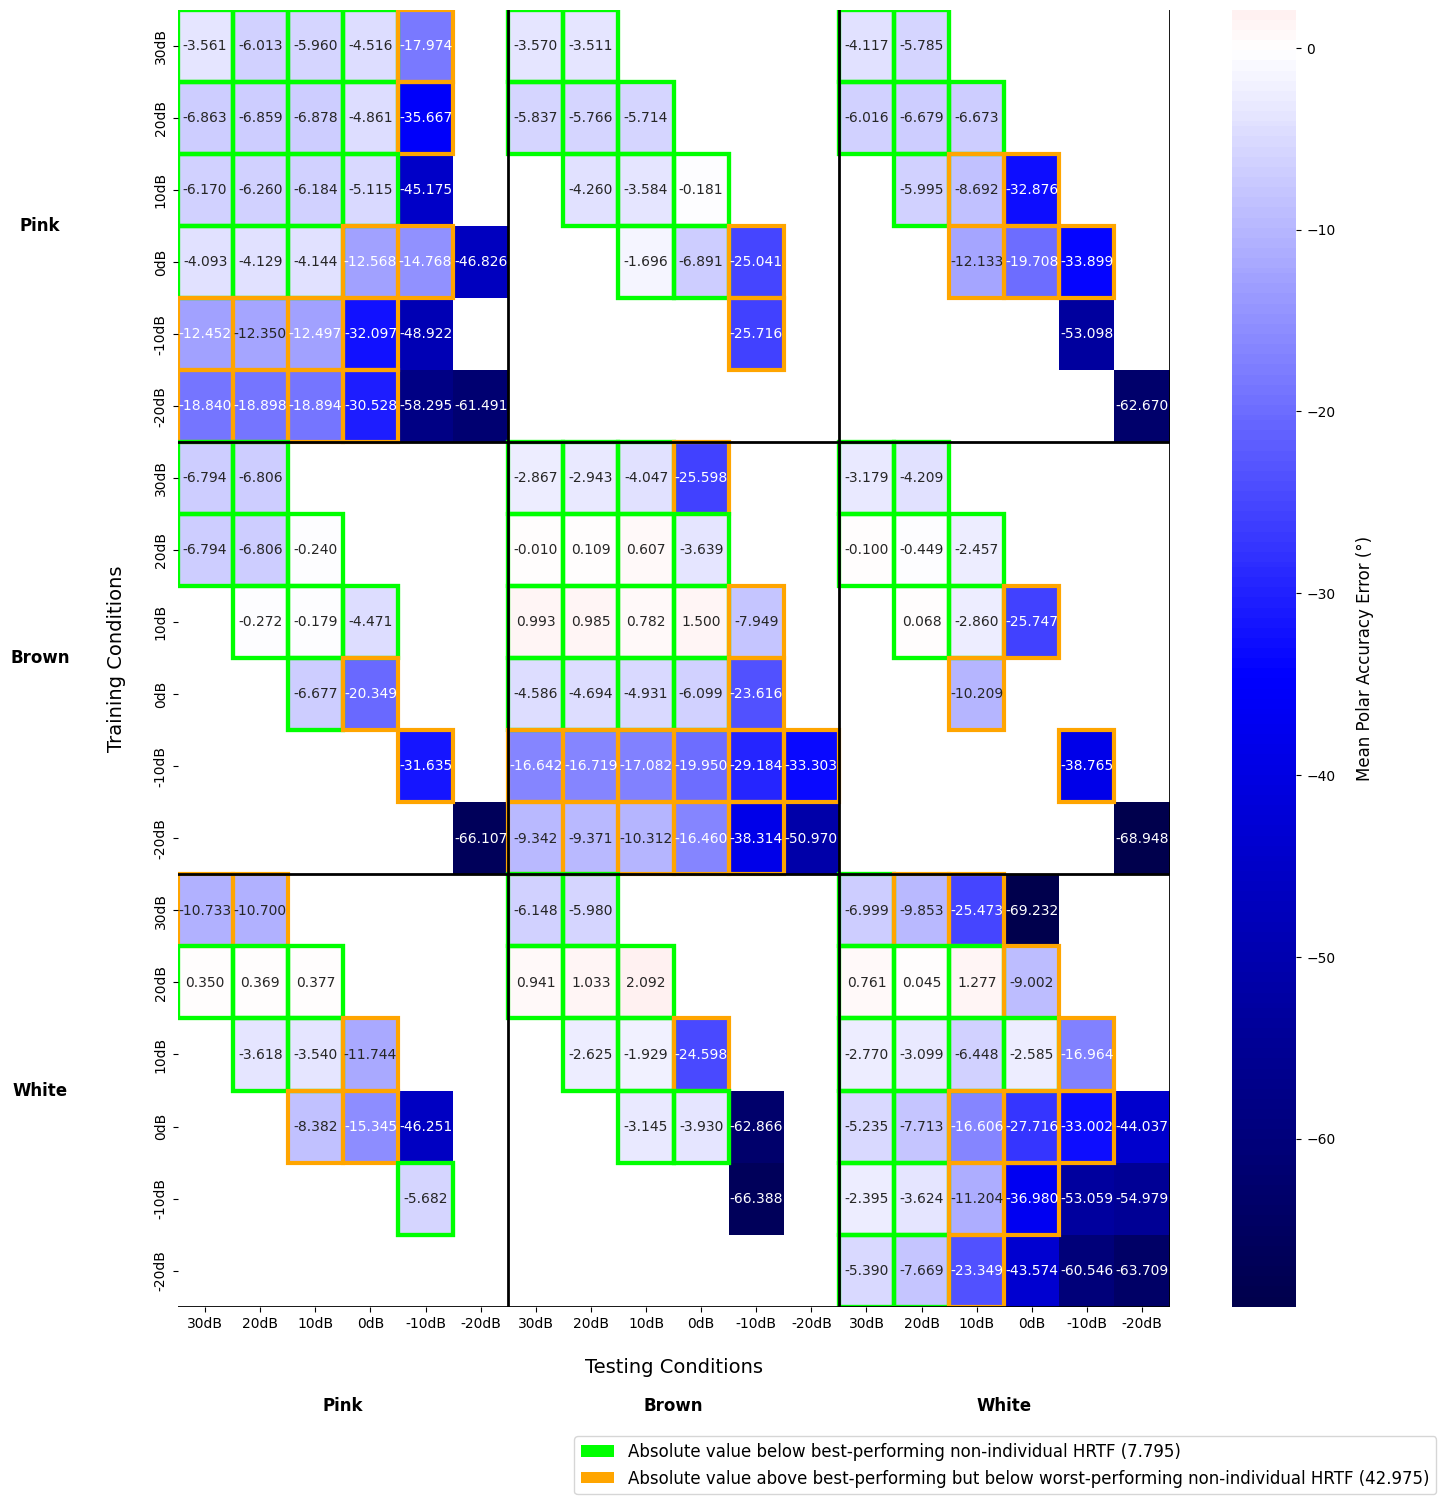

In [ ]:
"""
This cell creates the figure depicting the heat map for the mean polar accuracy errors. This is a separate cell because it follows a different coloring mechanism compared
to the other heat maps (i.e. a blue color for negative values, white for 0 and red for positive values)
"""

# Define performance thresholds
best = 7.795
worst = 42.975

# Use absolute values for comparison
abs_data = data.abs()

# Create masks for highlighting
mask_best = abs_data < best
mask_between = (abs_data >= best) & (abs_data <= worst)

# Mask NaN values
masked_data = np.ma.masked_invalid(data)

# Set up the figure with a larger size
plt.figure(figsize=(15, 15))

# Create the main heatmap with a diverging colormap (seismic)
heatmap = sns.heatmap(masked_data, annot=True, fmt=".3f", cmap="seismic", cbar_kws={'label': 'LSD'}, center=0)

# Get the axis object for adding patches
ax = plt.gca()

# Function to add borders to cells based on a mask and data value
def add_borders(data, abs_data, mask, color, lw):
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask.iloc[i, j]:
                # Add separate rectangle for each cell in mask_between
                rect = Rectangle((j, i), 1, 1, fill=False, edgecolor=color, lw=lw)
                ax.add_patch(rect)
            elif abs_data.iloc[i, j] < best:
                # Apply bright green border only if absolute value is smaller than `best`
                rect = Rectangle((j, i), 1, 1, fill=False, edgecolor='lime', lw=3)
                ax.add_patch(rect)

# Add borders for best performing cells with active green color
add_borders(data, abs_data, mask_best, 'lime', 3)  # Active green color with linewidth 3

# Add borders for cells between the thresholds with neon orange color
add_borders(data, abs_data, mask_between, '#FFA500', 3)  # Neon orange color with linewidth 3

# Add custom lines to separate noise types
lines_positions = [6, 12, 18]
for pos in lines_positions:
    ax.axhline(pos, color='black', linewidth=2)
    ax.axvline(pos, color='black', linewidth=2)

# Add noise type headings on both axes
noise_types = data.index.str.split(' ').str[0].unique()
for i, noise_type in enumerate(noise_types):
    ax.text(-2.5, i * 6 + 3, noise_type, ha="center", va="center", rotation=0, fontsize=12, weight='bold')

# Adjust y-coordinate for the top noise type labels
for i, noise_type in enumerate(noise_types):
    ax.text(i * 6 + 3, 19.5, noise_type, ha="center", va="bottom", rotation=0, fontsize=12, weight='bold')

# Simplify column and row labels
ax.set_xticks(np.arange(len(data.columns)) + 0.5)
ax.set_xticklabels([label.split(' ')[-2] for label in data.columns])

ax.set_yticks(np.arange(len(data.index)) + 0.5)
ax.set_yticklabels([label.split(' ')[-2] for label in data.index])

# Set labels and title
plt.xlabel('Testing Conditions', labelpad=20, fontsize=14)
plt.ylabel('Training Conditions', labelpad=20, fontsize=14)
#plt.title('Figure 10: Heat Map of Mean Polar Accuracy Errors (°) Across Training and Testing Conditions', fontsize=16)

# Customize colorbar ticks and label
cbar = heatmap.collections[0].colorbar
#min_lsd = np.round(abs_data.min().min(), decimals=0)  # Minimum non-NaN LSD value
#max_lsd = np.round(abs_data.max().max(), decimals=0)  # Maximum non-NaN LSD value
#cbar.set_ticks([min_lsd, max_lsd])  # Display min and max LSD values rounded to nearest whole number
cbar.set_label('Mean Polar Accuracy Error (°)', labelpad=15, fontsize=12)

# Adjust legend position next to "Testing Conditions" label on the right side
legend_texts = [
    'Absolute value below best-performing non-individual HRTF (7.795)',
    'Absolute value above best-performing but below worst-performing non-individual HRTF (42.975)'
]

legend_colors = ['lime', '#FFA500']  # Use 'lime' instead of hex code for active green
legend_patches = [Rectangle((0, 0), 1, 1, linewidth=0, edgecolor=color, facecolor=color) for color in legend_colors]

# Position the legend next to "Testing Conditions" label on the right side
plt.legend(legend_patches, legend_texts, loc='upper left', fontsize=12, bbox_to_anchor=(0.4, -0.1), borderaxespad=0.)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/heatmap_matrix_mean_polar_acc_error.png', dpi=300)

# Show the plot
plt.show()


In [ ]:
"""
This cell plots the figure that shows how changing the train noise type changes the LSD for every noise type, holding the test noise type constant
"""

# Step 1: Calculate the baseline LSD (when Train Noise Type equals Test Noise Type)
baseline = data[data['Train Noise Type'] == data['Test Noise Type']].copy()
baseline.rename(columns={'LSD': 'LSD_baseline'}, inplace=True)

# Step 2: Merge the baseline data with the original data
merged = pd.merge(data, baseline[['Test Noise Type', 'Train Noise Level', 'LSD_baseline']],
                  on=['Test Noise Type', 'Train Noise Level'])

# Step 3: Calculate the relative change in LSD
merged['LSD_change'] = merged['LSD'] - merged['LSD_baseline']

# Filter out rows where Train Noise Type equals Test Noise Type
filtered_grouped = merged[merged['Train Noise Type'] != merged['Test Noise Type']]

# Define the order of Test Noise Types
test_order = ['Brown', 'Pink', 'White']  # Define the overall order of Test Noise Types

# Define the order of Train Noise Types for each Test Noise Type
train_order_white = ['Brown', 'Pink', 'White']  # Define the order of Train Noise Types when Test Noise Type is White
train_order_other = ['Brown', 'White', 'Pink']  # Define the order of Train Noise Types for other Test Noise Types

# Define the color mapping for each noise type
color_map = {'Brown': 'brown', 'Pink': 'hotpink', 'White': 'cyan'}

# Plotting with adjusted color palette and bar width
plt.figure(figsize=(12, 8))

# Initialize legend handles and labels
handles = []
labels = []

# Iterate over each Test Noise Type and plot bars for each Train Noise Type
for i, test_type in enumerate(test_order):
    # Filter subset for the current Test Noise Type
    subset = filtered_grouped[filtered_grouped['Test Noise Type'] == test_type]

    # Determine the order of Train Noise Types based on Test Noise Type
    if test_type == 'White':
        order = train_order_white
    else:
        order = train_order_other

    # Plot bars for current Test Noise Type and collect handles and labels
    ax = sns.barplot(data=subset, x='Test Noise Type', y='LSD_change', hue='Train Noise Type', palette=color_map, dodge=True, order=[test_type], errorbar=None)

    # Add labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge')

    handles_ax, labels_ax = ax.get_legend_handles_labels()
    handles.extend(handles_ax)
    labels.extend(labels_ax)

# Create legend with correct labels and handles
legend_labels = ['Brown', 'Pink', 'White']
legend_handles = [plt.Line2D([0, 1], [0, 0], color=color_map[label], linestyle='-') for label in legend_labels]

plt.legend(legend_handles, legend_labels, title='Train Noise Type')

#plt.title('Average Relative LSD Change When Train Noise Type Differs from Test Noise Type')
plt.xlabel('Test Noise Type')
plt.ylabel('Change in LSD')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/average_change_in_LSD_when_training_with_different_noise_types.png', dpi=300)

plt.show()

SyntaxError: incomplete input (<ipython-input-1-d7aeca045249>, line 1)

In [ ]:
"""
A cell for calculating the average performance of high-SNR and low-SNR models across the four metrics
"""
# Define SNR levels
high_snr_levels = [30, 20]
low_snr_levels = [10, 0, -10, -20]

# Define the metrics to calculate
metrics = ['Mean Polar ACC Error (Degrees)', 'Mean Polar RMS Error (Degrees)', 'Mean Quadrant Error (%)', 'LSD']

# Drop rows with NaN values in the metrics columns
data_clean = data.dropna(subset=metrics)

# Filter the dataframe for high SNR models
high_snr_data = data_clean[data_clean['Train Noise Level'].isin(high_snr_levels)]

# Filter the dataframe for low SNR models
low_snr_data = data_clean[data_clean['Train Noise Level'].isin(low_snr_levels)]

# Group by test condition and test noise level, then calculate the average for high SNR models
high_snr_avg = high_snr_data.groupby(['Test Noise Type', 'Test Noise Level'])[metrics].mean().reset_index()
high_snr_avg['SNR_category'] = 'High SNR'

# Group by test condition and test noise level, then calculate the average for low SNR models
low_snr_avg = low_snr_data.groupby(['Test Noise Type', 'Test Noise Level'])[metrics].mean().reset_index()
low_snr_avg['SNR_category'] = 'Low SNR'

# Combine the high and low SNR averages into one dataframe
combined_avg = pd.concat([high_snr_avg, low_snr_avg])

# Round the results to 3 decimal places
combined_avg = combined_avg.round(3)

# Display the result
#print(combined_avg)

# Define the output file path
output_file_path = '/content/drive/My Drive/HRTF_noise/results_for_graphs/perceptual_results_grouped_by_SNR_type.csv'

# Save the combined average to a CSV file
combined_avg.to_csv(output_file_path, index=False)


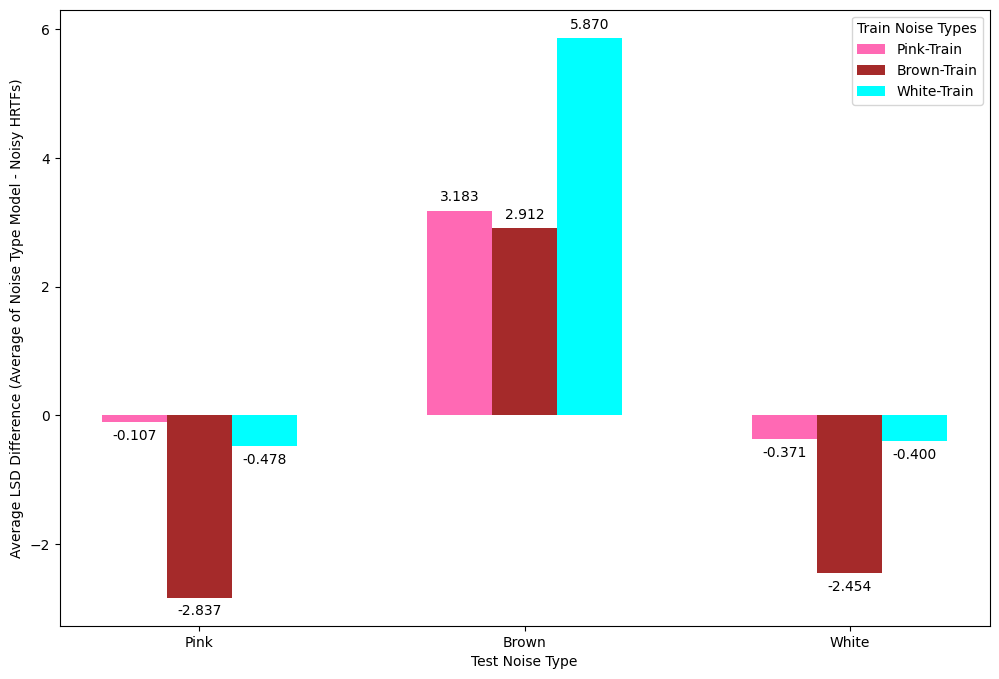

In [ ]:
"""
This cell creates the figure that depicts the average LSD performance difference between a given noise-type model and the raw noisy files directly for every test noise type
"""

# Read data
file_path = '/content/drive/My Drive/HRTF_noise/results_for_graphs/Noisy Valid Data Experiments.csv'
data = pd.read_csv(file_path, na_values=['NaN', ''])

# Noise types and corresponding colors
noise_types = ['Pink', 'Brown', 'White']
colors = {'Pink': 'hotpink', 'Brown': 'brown', 'White': 'cyan'}

# Initialize a dictionary to store the average differences for each test noise
avg_diff = {test_noise: [] for test_noise in noise_types}

# Calculate the average differences for each test noise condition
for test_noise in noise_types:
    for noise in noise_types:
        # Filter data for the current test noise condition
        noise_data = data[data['Test Noise Type'].str.contains(test_noise)]

        # Calculate the differences
        differences = noise_data[f'Avg LSD For {noise}-Train-Generated HRTFs'] - noise_data['LSD Noisy HRTFs']

        # Store the mean of differences
        avg_diff[test_noise].append(differences.mean())

# Plotting
plt.figure(figsize=(12, 8))

# Define positions for bars
bar_width = 0.2
index = range(len(noise_types))  # Positions for the x-axis

# Plot bars for each noise type separately
for i, noise in enumerate(noise_types):
    x_positions = [idx + i * bar_width for idx in index]
    plt.bar(x_positions, [avg_diff[test_noise][i] for test_noise in noise_types], width=bar_width, color=colors[noise], label=f'{noise}-Train')

    # Add labels on top or below each bar depending on whether the height is positive or negative
    for x, height in zip(x_positions, [avg_diff[test_noise][i] for test_noise in noise_types]):
        plt.text(
            x,
            height + 0.1 if height >= 0 else height - 0.1,  # Slightly above or below the bar
            f'{height:.3f}',  # Formatting the number to 3 decimal places
            ha='center',
            va='bottom' if height >= 0 else 'top'
        )

# Set x-axis labels and ticks
plt.xlabel('Test Noise Type')
plt.ylabel('Average LSD Difference (Average of Noise Type Model - Noisy HRTFs)')
plt.xticks([i + bar_width for i in index], noise_types)  # Position ticks in the middle of grouped bars

# Add legend
plt.legend(title='Train Noise Types')

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/noisy_HRTF_vs_Avg_Models.png', dpi=300)

plt.show()

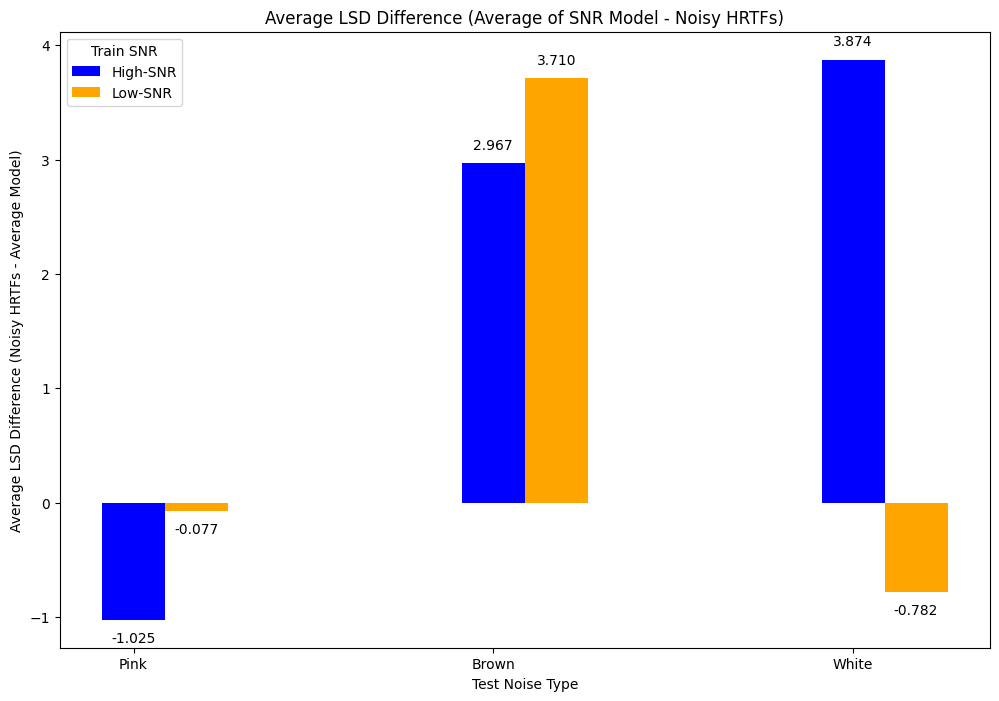

In [ ]:
"""
This cell creates the figure that depicts the average LSD performance difference between either high-SNR or low-SNR models and the raw noisy files directly for every test noise type
"""

# Read data
file_path = '/content/drive/My Drive/HRTF_noise/results_for_graphs/Noisy Valid Data Experiments.csv'
data = pd.read_csv(file_path, na_values=['NaN', ''])

# Noise types and corresponding colors
noise_types = ['Pink', 'Brown', 'White']
colors = {'High-SNR': 'blue', 'Low-SNR': 'orange'}  # Colors for SNR categories

# Initialize a dictionary to store the average differences
avg_diff = {test_noise: {'High-SNR': [], 'Low-SNR': []} for test_noise in noise_types}

# Calculate the average differences for each test noise and SNR condition
for test_noise in noise_types:
    noise_data = data[data['Test Noise Type'].str.contains(test_noise)]

    # Calculate differences for High-SNR
    high_snr_differences = noise_data[f'Avg LSD For High-SNR-Train-Generated HRTFs (30dB, 20dB)'] - noise_data['LSD Noisy HRTFs']
    avg_diff[test_noise]['High-SNR'] = high_snr_differences.mean()

    # Calculate differences for Low-SNR
    low_snr_differences = noise_data[f'Avg LSD For Low-SNR-Train-Generated HRTFs (10dB, 0dB, -10dB, -20dB)'] - noise_data['LSD Noisy HRTFs']
    avg_diff[test_noise]['Low-SNR'] = low_snr_differences.mean()

# Plotting
plt.figure(figsize=(12, 8))

# Define positions for bars
bar_width = 0.35  # Adjust width for two bars per category
index = range(len(noise_types))  # Positions for the x-axis

# Plot bars for each test noise and SNR type
snr_types = ['High-SNR', 'Low-SNR']  # Labels for SNR categories
bar_positions = [i + bar_width / 2 for i in index]  # Positions for each bar within a category

for i, test_noise in enumerate(noise_types):
    for j, snr_type in enumerate(snr_types):
        x_position = bar_positions[i] + j * (bar_width / len(snr_types))
        plt.bar(
            x_position,
            avg_diff[test_noise][snr_type],
            width=bar_width / len(snr_types),
            color=colors[snr_type],
            label=snr_type if i == 0 else None  # Only add label for the first bar in each group
        )

        # Add labels on top or below each bar depending on height
        plt.text(
            x_position,
            avg_diff[test_noise][snr_type] + 0.1 if avg_diff[test_noise][snr_type] >= 0 else avg_diff[test_noise][snr_type] - 0.1,
            f'{avg_diff[test_noise][snr_type]:.3f}',  # Formatting the number
            ha='center',
            va='bottom' if avg_diff[test_noise][snr_type] >= 0 else 'top'
        )

# Set x-axis labels and ticks
plt.xlabel('Test Noise Type')
plt.ylabel('Average LSD Difference (Noisy HRTFs - Average Model)')
plt.xticks([i + bar_width / 2 for i in index], noise_types)  # Position ticks in the middle of grouped bars

# Add legend and title
plt.legend(title='Train SNR')
plt.title('Average LSD Difference (Average of SNR Model - Noisy HRTFs)')

# Save the plot
plt.savefig('/content/drive/My Drive/HRTF_noise/results_for_graphs/figures/noisy_HRTF_vs_Avg_Models_SNR.png', dpi=300)

plt.show()